In [1]:
# 加载数据
import torch
from joblib import dump, load
import torch.utils.data as Data
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
# 参数与配置
torch.manual_seed(100)  # 设置随机种子，以使实验结果具有可重复性
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载数据集
def dataloader(batch_size, workers=2):
    # 训练集
    train_set = load('c_train_set')
    train_label = load('c_train_label')
    # 测试集
    test_set = load('c_test_set')
    test_label = load('c_test_label')

    # 加载数据
    train_loader = Data.DataLoader(dataset=Data.TensorDataset(train_set, train_label),
                                   batch_size=batch_size, num_workers=workers, drop_last=True)
    test_loader = Data.DataLoader(dataset=Data.TensorDataset(test_set, test_label),
                                  batch_size=batch_size, num_workers=workers, drop_last=True)
    return train_loader, test_loader

batch_size = 64
# 加载数据
train_loader, test_loader = dataloader(batch_size)

In [2]:
print(len(train_loader))
print(len(test_loader))
print("2")

21
5
2


定义自注意力机制

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SelfAttention(nn.Module):
    def __init__(self, embed_dim):
        super(SelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)

        attention_weights = F.softmax(torch.matmul(q, k.transpose(1, 2)) / torch.sqrt(torch.tensor(self.embed_dim)), dim=-1)
        output = torch.matmul(attention_weights, v)
        # print("SelfAttention shape:"+str(output.shape))
        return output

In [4]:
# 定义 EALSETM 模型
class EALSETM(nn.Module):
    def __init__(self, batch_size, input_dim, hidden_layer_sizes, output_dim, attention_dim):
        """
        预测任务  params:
         batch_size       : 批次量大小
        input_dim         : 输入数据的维度
        hidden_layer_size : 隐层的数目和维度
        output_dim        : 输出维度
        attention_dim     : 自注意力机制维度

        """
        super().__init__()
        # 批次量大小
        self.batch_size = batch_size
        # lstm层数
        self.num_layers = len(hidden_layer_sizes)
        self.hidden_layer_sizes = len(hidden_layer_sizes)
        self.lstm_layers = nn.ModuleList()  # 用于保存LSTM层的列表

        # 定义第一层LSTM
        self.lstm_layers.append(nn.LSTM(input_dim, hidden_layer_sizes[0], batch_first=True))

        # 定义后续的LSTM层
        for i in range(1, self.num_layers):
                self.lstm_layers.append(nn.LSTM(hidden_layer_sizes[i-1], hidden_layer_sizes[i], batch_first=True))

        # 定义自注意力层
        self.attention = SelfAttention(attention_dim)

         # 序列平均池化操作
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)


        # 定义线性层
        self.linear  = nn.Linear(hidden_layer_sizes[-1], output_dim)


    def forward(self, input_seq):  # torch.Size([16, 512])
        # 前向传播的过程是输入->LSTM层->全连接层->输出
        # 在观察查看LSTM输入的维度，LSTM的第一个输入input_size维度是(batch, seq_length, dim) batch是batch size , seq_length是序列长度，dim是输入维度，也就是变量个数
        # LSTM的第二个输入是一个元组，包含了h0,c0两个元素，这两个元素的维度都是（D∗num_layers,N,out)，
        # D=1表示单向网络，num_layers表示多少个LSTM层叠加，N是batch size，out表示隐层神经元个数

        # 数据预处理
        #改变输入形状，适应网络输入[batch, seq_length, dim]
        lstm_out = input_seq
        # 获取隐藏层数据
        hidden_states = []
        for lstm in self.lstm_layers:
            lstm_out, hidden= lstm(lstm_out)  ## 进行一次LSTM层的前向传播
            hidden_states += hidden
        # print("lstm_out.size"+str(lstm_out.size()))  # torch.Size([64, 7, 64])

        # 送入注意力机制层
        attention_features = self.attention(lstm_out)  # torch.Size([64, 7, 64])

         # 自适应平均池化
        x = self.adaptive_pool(attention_features.permute(0,2,1))  # torch.Size([64, 64, 1])
        # 平铺
        x = x.view(self.batch_size, -1)  # 把数据平铺
        # 全连接层
        predict = self.linear(x) # torch.Size([64, 10]
        return predict

输入数据的形状是
 1. print(seq.size(), labels.size())
 2. torch.Size([64, 7, 10])    torch.Size([64, 10])

In [5]:
# 定义模型参数
batch_size = 64
"这里将input_dim从10改为8"
input_dim = 8   # 输入维度为10个分量
hidden_layer_sizes = [32, 64] # LSTM隐藏层
attention_dim = hidden_layer_sizes[-1]  # 注意力层维度 默认为 LSTM输出层维度
"这里将output_dim从10改为8"
output_dim = 8 # 输出维度10

model = EALSETM(batch_size, input_dim, hidden_layer_sizes, output_dim, attention_dim)

# 定义损失函数和优化函数
loss_function = nn.MSELoss()  # loss
learn_rate =  0.0003
optimizer = torch.optim.Adam(model.parameters(), learn_rate)  # 优化器

# 输出网络结构总共有多少参数
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)


  1024
  4096
   128
   128
  8192
 16384
   256
   256
  4096
    64
  4096
    64
  4096
    64
   512
     8
______
 43464


In [6]:
print(model)

EALSETM(
  (lstm_layers): ModuleList(
    (0): LSTM(8, 32, batch_first=True)
    (1): LSTM(32, 64, batch_first=True)
  )
  (attention): SelfAttention(
    (query): Linear(in_features=64, out_features=64, bias=True)
    (key): Linear(in_features=64, out_features=64, bias=True)
    (value): Linear(in_features=64, out_features=64, bias=True)
  )
  (adaptive_pool): AdaptiveAvgPool1d(output_size=1)
  (linear): Linear(in_features=64, out_features=8, bias=True)
)


Epoch:  1 train_MSE-Loss: 0.01703412
Epoch:  1 test_MSE_Loss:0.01062773


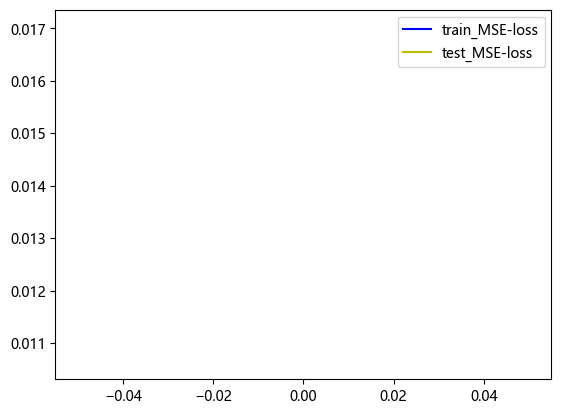

min_MSE: 0.010627728886902332


In [7]:
# 训练模型
import time
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("font", family='Microsoft YaHei')

def model_train(batch_size, epochs, model, optimizer, loss_function, train_loader, test_loader):
    model = model.to(device)
    # 样本长度
    train_size = len(train_loader) * batch_size
    test_size = len(test_loader) * batch_size

    # 最低MSE
    minimum_mse = 1000.
    # 最佳模型
    best_model = model

    train_mse = []     # 记录在训练集上每个epoch的 MSE 指标的变化情况   平均值
    test_mse = []      # 记录在测试集上每个epoch的 MSE 指标的变化情况   平均值

    # 计算模型运行时间
    start_time = time.time()
    for epoch in range(epochs):
         # 训练
        model.train()

        train_mse_loss = 0.    #保存当前epoch的MSE loss和
        for seq, labels in train_loader:
            seq, labels = seq.to(device), labels.to(device)
            # 每次更新参数前都梯度归零和初始化
            optimizer.zero_grad()
            # 前向传播
            y_pred = model(seq)  #   torch.Size([16, 10])
            # 损失计算
            loss = loss_function(y_pred, labels)
            train_mse_loss += loss.item() # 计算 MSE 损失
            # 反向传播和参数更新
            loss.backward()
            optimizer.step()
        #     break
        # break
        # 计算总损失
        train_av_mseloss = train_mse_loss/train_size
        train_mse.append(train_av_mseloss)

        print(f'Epoch: {epoch+1:2} train_MSE-Loss: {train_av_mseloss:10.8f}')
        # 每一个epoch结束后，在验证集上验证实验结果。
        with torch.no_grad():
            test_mse_loss = 0.    #保存当前epoch的MSE loss和
            for data, label in test_loader:
                data, label = data.to(device), label.to(device)
                pre = model(data)
                # 计算损失
                test_loss = loss_function(pre, label)
                test_mse_loss += test_loss.item()

            # 计算总损失
            test_av_mseloss = test_mse_loss/test_size
            test_mse.append(test_av_mseloss)
            print(f'Epoch: {epoch+1:2} test_MSE_Loss:{test_av_mseloss:10.8f}')
            # 如果当前模型的 MSE 低于于之前的最佳准确率，则更新最佳模型
            #保存当前最优模型参数
            if test_av_mseloss < minimum_mse:
                minimum_mse = test_av_mseloss
                best_model = model# 更新最佳模型的参数

   # 模型预测
    torch.save(model, 'final_model_lstm_att.pt')
    # 保存最好的参数
    # best_model.LSTM.bias.data
    # torch.save(best_model, 'test1.pt')

    # torch.load("carbon_pre_best_model_test1.pt")
    # 损失函数可视化
    plt.plot(range(epochs), train_mse, color = 'b',label = 'train_MSE-loss')
    plt.plot(range(epochs), test_mse, color = 'y',label = 'test_MSE-loss')
    plt.legend()
    plt.show()   #显示 lable
    print(f'min_MSE: {minimum_mse}')


#  模型训练
# batch_size = 64
epochs = 1
model_train(batch_size, epochs, model, optimizer, loss_function, train_loader, test_loader)

In [8]:
# 模型预测
# 模型 测试集 验证
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.load('carbon_pre_best_model.pt')
model = model.to(device)

# 分量数据数组
original_IMFs = []
# 预测分量数据数组
pre_IMFs = []
#测试无需跟踪梯度信息
with torch.no_grad():
        for data, label in test_loader:
            model.eval()  # 将模型设置为评估模式

            # 原始分量
            original = label.tolist()
            original_IMFs += original

            # 预测
            data, label = data.to(device), label.to(device)
            test_pred = model(data)  # 对测试集进行预测
            # 预测分量
            pre = test_pred.tolist()
            pre_IMFs += pre

In [9]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 将二维列表转换为 NumPy 数组
original_IMFs = np.array(original_IMFs)
original_IMFs.reshape(-1)
pre_IMFs = np.array(pre_IMFs)
pre_IMFs.reshape(-1)

# 反归一化处理
# 使用相同的均值和标准差对预测结果进行反归一化处理
# 反标准化
scaler  = load('scaler ')
original_IMFs = scaler.inverse_transform(original_IMFs)
pre_IMFs = scaler.inverse_transform(pre_IMFs)

# 测试集重构数据
# 按列求和
original_data = np.sum(original_IMFs, axis=1)
# 预测重构数据
pre_data = np.sum(pre_IMFs, axis=1)
print("预测重构数据为："+str(pre_data))

预测重构数据为：[26760.22707406 26881.57159487 27009.19170379 27152.76300701
 27385.13138211 27653.77633888 27854.10329942 28004.18156278
 28071.6557712  28163.09321575 28326.14348479 28546.84397812
 28780.40499343 29005.40651509 29177.18928608 29299.17016643
 29397.03954872 29513.71318813 29634.25529895 29732.73905826
 29815.51016358 29883.23083749 29915.51510965 29904.81852554
 29856.55151155 29762.89383762 29641.13255224 29504.56002503
 29377.08563696 29364.21786202 29500.15472554 29791.46342701
 30200.80877595 30637.67598588 31051.50259805 31463.64530343
 31854.36738517 32218.41228266 32518.70201889 32713.45759217
 32717.05102602 32612.52708075 32534.76832031 32542.03661363
 32579.66713606 32649.28639858 32756.32777992 32907.68763198
 33045.7153715  33158.60122058 33222.46644135 33260.14698643
 33277.38008821 33270.60303023 33215.68197206 33112.75096442
 32979.23409507 32827.94235375 32688.22534878 32611.20185594
 32601.50119798 32633.5788978  32709.64094924 32803.62704782
 32907.30984177 

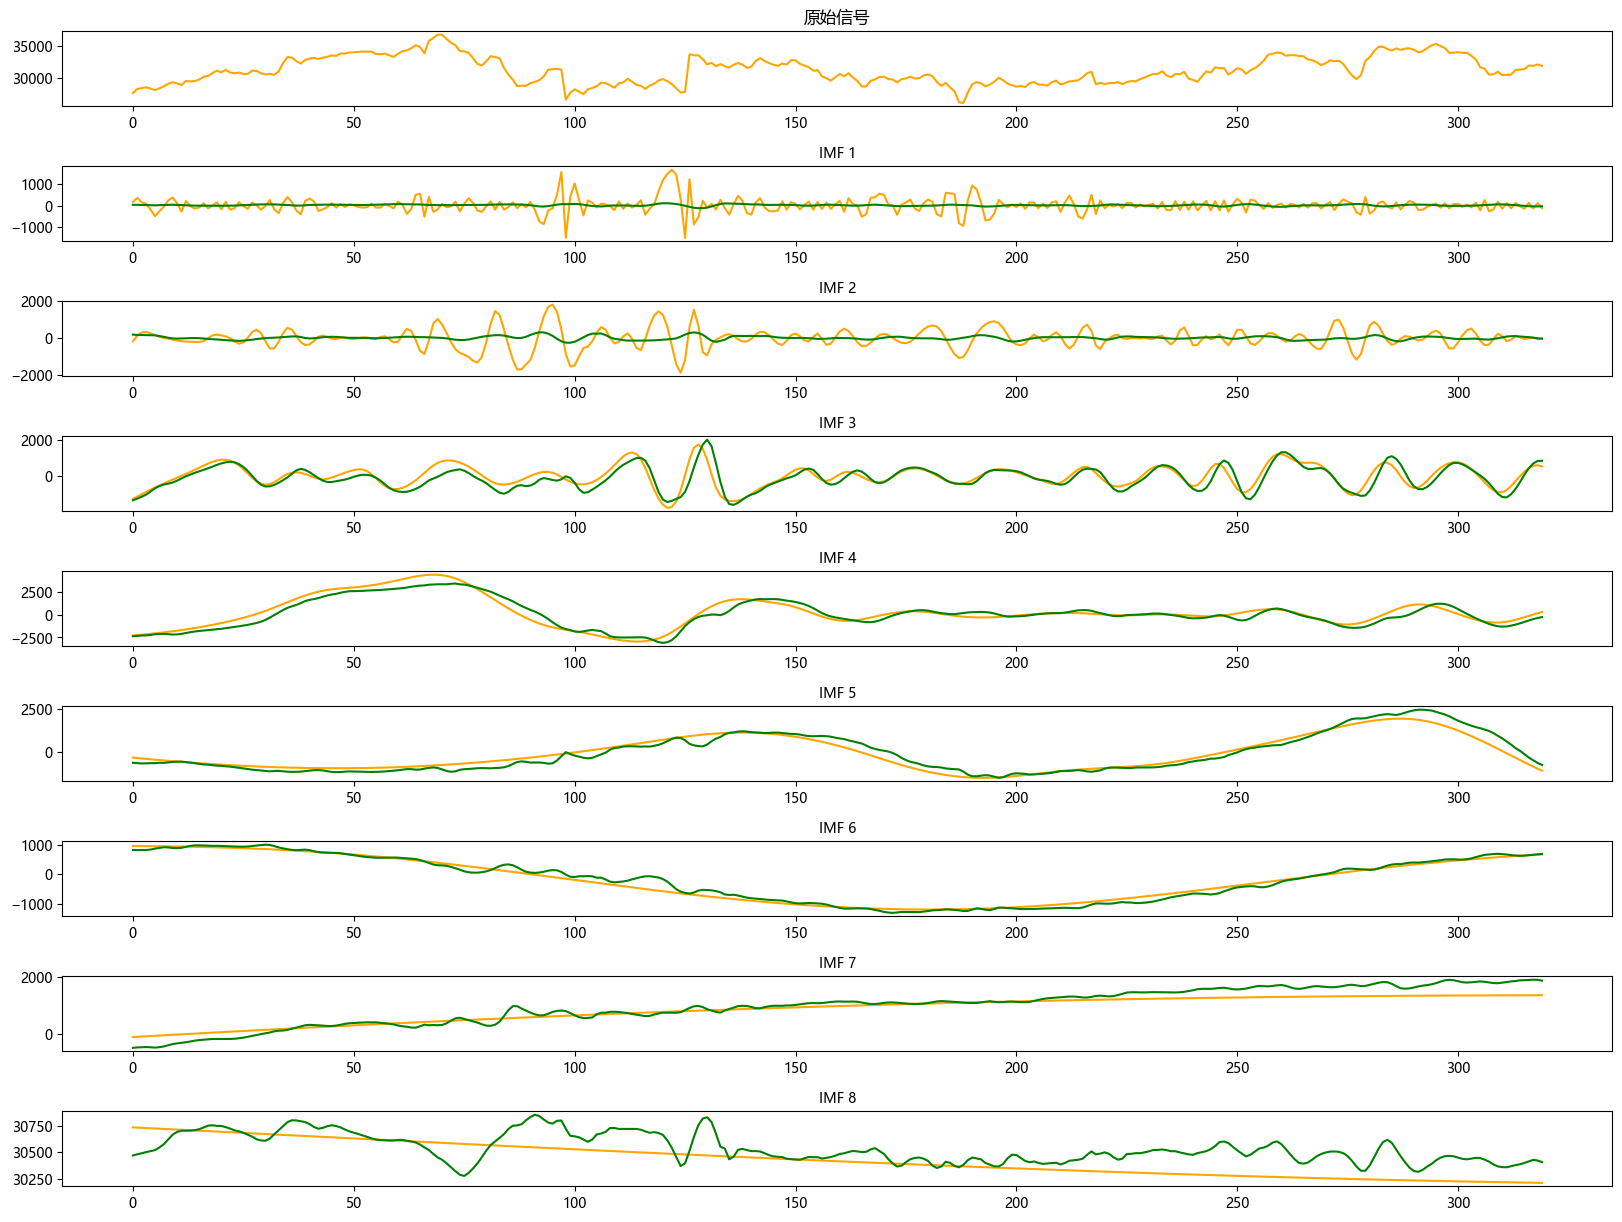

In [10]:
# 获取数组的行数和列数
num_rows, num_columns = original_IMFs.shape

# 可视化
plt.figure(figsize=(20,15))
plt.subplot(num_columns+1, 1, 1)
plt.plot(original_data, label='True',color='orange')
# plt.plot(pre_data, label='Predicted',color='green')
plt.title("原始信号")

# 循环绘制每一列的折线图
for col in range(num_columns):
    plt.subplot(num_columns+1, 1, col+2)
    plt.plot(original_IMFs[:, col], label=f'origin_IMF {col + 1}', color='orange')
    plt.plot(pre_IMFs[:, col], label=f'pre_IMF {col + 1}', color='green')
    plt.title("IMF "+str(col+1), fontsize=10)
# 增加第一排图和第二排图之间的垂直间距
plt.subplots_adjust(hspace=0.8, wspace=0.2)
plt.show()

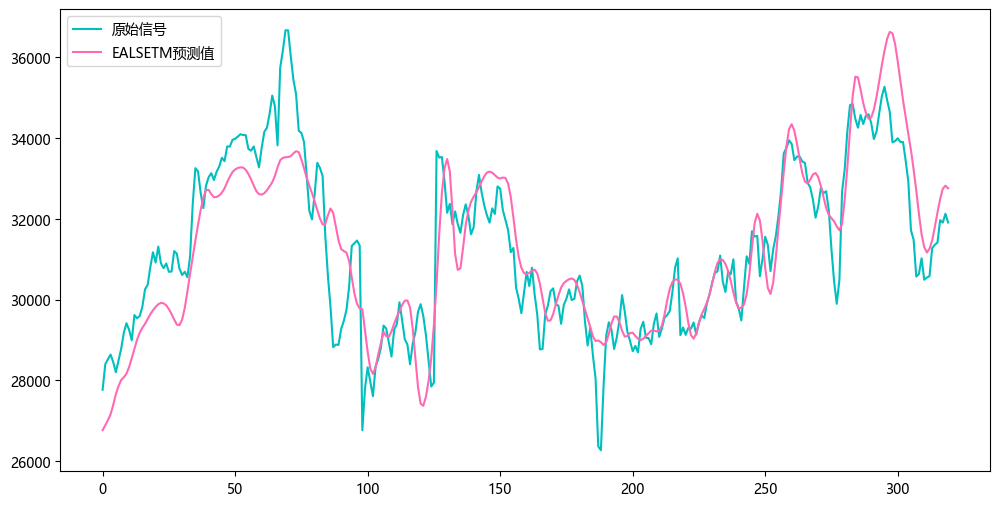

In [11]:
# 可视化结果
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(original_data, label='原始信号',color='c')  # 真实值
plt.plot(pre_data, label='EALSETM预测值',color='hotpink')  # 预测值
plt.legend()
plt.show()

In [12]:
#模型性能评价
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 模型分数
score = r2_score(original_data, pre_data)
print('*'*50)
print('EALSETM模型分数--R^2:',score)

print('*'*50)
# 测试集上的预测误差
test_mse = mean_squared_error(original_data, pre_data)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(original_data, pre_data)
print('测试数据集上的均方误差--MSE: ',test_mse)
print('测试数据集上的均方根误差--RMSE: ',test_rmse)
print('测试数据集上的平均绝对误差--MAE: ',test_mae)
def calculate_mape(y_true, y_pred):
    n = len(y_true)
    absolute_percentage_errors = []

    for i in range(n):
        absolute_percentage_errors.append(abs((y_true[i] - y_pred[i]) / y_true[i]))

    mape = (sum(absolute_percentage_errors) / n) * 100

    return mape
mape = calculate_mape(original_data,pre_data)
print("测试数据集上的MAPE:",mape)




**************************************************
EALSETM模型分数--R^2: 0.7378209635125867
**************************************************
测试数据集上的均方误差--MSE:  1122430.0046640649
测试数据集上的均方根误差--RMSE:  1059.4479716645196
测试数据集上的平均绝对误差--MAE:  818.5397243917271
测试数据集上的MAPE: 2.6149075791470358
